### oxford_flowers102 dataseti

In [1]:
import tensorflow as tf

In [2]:
data_name = 'oxford_flowers102'

#### Tensorflow datasetlaridan uc_merged datasetini yuklab olamiz

In [3]:
import tensorflow_datasets as tfds

(train,test,validation), info = tfds.load(
    data_name,
    split=['test','train','validation'],
    data_dir="dataset\\",
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    batch_size=-1
)

In [4]:
info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

#### Image va labellarni preprocessingdan o'tkazamiz 

In [5]:
train_images,train_labels = tfds.as_numpy(train)
test_images,test_labels = tfds.as_numpy(test)
validation_images,validation_labels = tfds.as_numpy(validation)

In [6]:
import cv2
import numpy as np

def preprocessing(images,label):
    images_ = []
    
    for i in range(len(images)):
        image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,(224,224),interpolation = cv2.INTER_AREA)
        image = image/127.5-1.0
        image = image.astype('float16')
        
        images_.append(image)
        
    label = label.astype('uint16')
    images = np.array(images_)
    return images,label

In [7]:
train_images,train_labels = preprocessing(train_images,train_labels)
print(f"Train images shape:{train_images.shape}\nTrain labels shape:{train_labels.shape}")

Train images shape:(6149, 224, 224, 3)
Train labels shape:(6149,)


In [8]:
test_images,test_labels = preprocessing(test_images,test_labels)
print(f"Test images shape:{test_images.shape}\nTest labels shape:{test_labels.shape}")

Test images shape:(1020, 224, 224, 3)
Test labels shape:(1020,)


In [9]:
validation_images,validation_labels = preprocessing(validation_images,validation_labels)
print(f"Validation images shape:{validation_images.shape}\nValidation labels shape:{validation_labels.shape}")

Validation images shape:(1020, 224, 224, 3)
Validation labels shape:(1020,)


In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((test_images,test_labels)).batch(32)

validation_ds = tf.data.Dataset.from_tensor_slices((validation_images,validation_labels)).batch(32)

### Model o'qitish uchun VGG-19 arxitekturasidan foydalanamiz


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [12]:
class MyModel(tf.keras.models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.block1_1conv = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.relu, padding="same")
        self.block1_2conv = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.relu, padding="same")
        
        self.block2_1conv = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.relu, padding="same")
        self.block2_2conv = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.relu, padding="same")
        
        self.block3_1conv = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.relu, padding="same")
        self.block3_2conv = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.relu, padding="same")
        self.block3_3conv = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.relu, padding="same")
        self.block3_4conv = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.relu, padding="same")
        
        self.block4_1conv = tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.activations.relu, padding="same")
        self.block4_2conv = tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.activations.relu, padding="same")
        self.block4_3conv = tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.activations.relu, padding="same")
        self.block4_4conv = tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.activations.relu, padding="same")
        
        self.block5_1conv = tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.activations.relu, padding="same")
        self.block5_2conv = tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.activations.relu, padding="same")
        self.block5_3conv = tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.activations.relu, padding="same")
        self.block5_4conv = tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.activations.relu, padding="same")
        
        self.pool = tf.keras.layers.MaxPooling2D((2, 2),strides=2)
        
        self.flatten = tf.keras.layers.Flatten()
        self.hidden_layer1 = tf.keras.layers.Dense(4096, activation=tf.keras.activations.relu)
        self.hidden_layer2 = tf.keras.layers.Dense(4096, activation=tf.keras.activations.relu)
        self.hidden_layer3 = tf.keras.layers.Dense(1000, activation=tf.keras.activations.relu)
        self.output_layer = tf.keras.layers.Dense(102, activation=tf.keras.activations.softmax)
        
    def call(self, x):
        '''Convolutional Layer'''
        # Block 1
        conv1 = self.block1_1conv(x) # 224x224x64
        conv2 = self.block1_2conv(conv1) # 224x224x64
        pooling = self.pool(conv2) # 112x112x64

        # Block 2
        conv3 = self.block2_1conv(pooling) # 112x112x128
        conv4 = self.block2_2conv(conv3) # 112x112x128
        pooling = self.pool(conv4) # 56x56x128

        # Block 3
        conv5 = self.block3_1conv(pooling) # 56x56x256
        conv6 = self.block3_2conv(conv5) # 56x56x256
        conv7 = self.block3_3conv(conv6) # 56x56x256
        conv8 = self.block3_4conv(conv7) # 56x56x256
        pooling = self.pool(conv8) # 28x28x256
        
        # Block 4
        conv9  = self.block4_1conv(pooling) # 28x28x512
        conv10 = self.block4_2conv(conv9) # 28x28x512
        conv11 = self.block4_3conv(conv10) # 28x28x512
        conv12 = self.block4_4conv(conv11) # 28x28x512
        pooling = self.pool(conv12) # 14x14x512
        
        # Block 5
        conv13 = self.block5_1conv(pooling) # 14x14x512
        conv14 = self.block5_2conv(conv13) # 14x14x512
        conv15 = self.block5_3conv(conv14) # 14x14x512
        conv16 = self.block5_4conv(conv15) # 14x14x512
        pooling = self.pool(conv16) # 7x7x512
        
        '''Classification Layer'''
        flatten = self.flatten(pooling)
        
        hidden = self.hidden_layer1(flatten)
        hidden = self.hidden_layer2(hidden)
        hidden = self.hidden_layer3(hidden)
        
        return self.output_layer(hidden)

model = MyModel()

In [13]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

In [14]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [15]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:

        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [16]:
@tf.function
def test_step(images, labels):
    
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    

In [18]:
EPOCHS = 10

loss,val_loss = [],[]
accuracy, val_accuracy = [],[]

for epoch in range(EPOCHS):

    train_loss.reset_states()
    train_accuracy.reset_states()
    
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for val_images, val_labels in validation_ds:
        test_step(val_images, val_labels)
    
    loss.append(train_loss.result())
    accuracy.append(train_accuracy.result())
    
    val_loss.append(test_loss.result())
    val_accuracy.append(test_accuracy.result())
    
    print(f"** {epoch + 1}-epoch:\nloss: {train_loss.result()}\tsparse_categorical_accuracy: {train_accuracy.result()}\nval_loss: {test_loss.result()}\tval_sparse_categorical_accuracy:{test_accuracy.result()}")

** 1-epoch:
loss: 62.39342498779297	sparse_categorical_accuracy: 0.0351276621222496
val_loss: 4.952834129333496	val_sparse_categorical_accuracy:0.009803921915590763
** 2-epoch:
loss: 4.431094646453857	sparse_categorical_accuracy: 0.03756708279252052
val_loss: 4.864556789398193	val_sparse_categorical_accuracy:0.009803921915590763
** 3-epoch:
loss: 4.426392078399658	sparse_categorical_accuracy: 0.03610343113541603
val_loss: 4.809947490692139	val_sparse_categorical_accuracy:0.009803921915590763
** 4-epoch:
loss: 4.423429012298584	sparse_categorical_accuracy: 0.036266058683395386
val_loss: 4.7930121421813965	val_sparse_categorical_accuracy:0.009803921915590763
** 5-epoch:
loss: 4.421780586242676	sparse_categorical_accuracy: 0.036916572600603104
val_loss: 4.792108058929443	val_sparse_categorical_accuracy:0.009803921915590763
** 6-epoch:
loss: 4.420808792114258	sparse_categorical_accuracy: 0.038054969161748886
val_loss: 4.793202877044678	val_sparse_categorical_accuracy:0.009803921915590763
*

In [19]:
for test_images,test_labels in test_ds:
    test_step(test_images, test_labels)
    
print(f"test_loss: {test_loss.result()}\ntest_accuracy: {test_accuracy.result()}")

test_loss: 4.799952030181885
test_accuracy: 0.009803921915590763


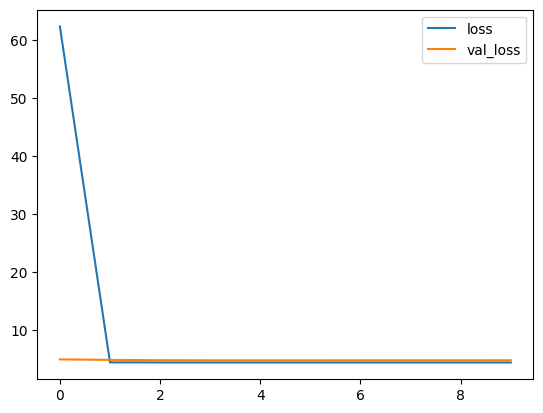

In [22]:
import matplotlib.pyplot as plt
epochs = [i for i in range(EPOCHS)]

plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.show()

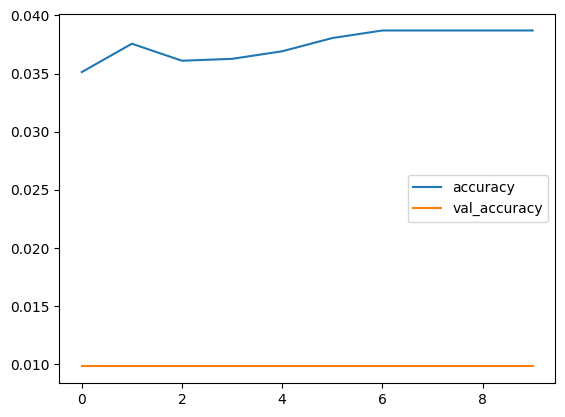

In [23]:
plt.plot(epochs, accuracy, label='accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.legend()
plt.show()

In [24]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1792      
                                                                 
 conv2d_1 (Conv2D)           multiple                  36928     
                                                                 
 conv2d_2 (Conv2D)           multiple                  73856     
                                                                 
 conv2d_3 (Conv2D)           multiple                  147584    
                                                                 
 conv2d_4 (Conv2D)           multiple                  295168    
                                                                 
 conv2d_5 (Conv2D)           multiple                  590080    
                                                                 
 conv2d_6 (Conv2D)           multiple                  590

In [25]:
model.save('models/VGG-19/model')

INFO:tensorflow:Assets written to: models/VGG-19/model\assets


INFO:tensorflow:Assets written to: models/VGG-19/model\assets
